In [159]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [160]:
df = pd.read_csv("dataprep.csv")  

In [161]:
df['Label'] = df.Label.map({'H':0, 'N':1})

In [162]:
df.head()

Label                                          Statement
0      0  @Grumpy_P_Sloth @deanesmay feminists argue for...
1      0  1948Army of England helped the Jews to occupy ...
2      0  Dutch Leader Says Europe to collapse In 6 Week...
3      0  RT @__DeLay: The next day the Romans and the J...
4      0  RT @Bakersman_Joe: When Hitler Invited The Jew...

In [163]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['Statement'].values)
X = tokenizer.texts_to_sequences(df['Statement'].values)
X = pad_sequences(X)

In [164]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(512,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(2,activation='sigmoid',kernel_initializer='glorot_normal'))
model.compile(loss = 'kullback_leibler_divergence', optimizer='Nadam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 39, 128)           256000    
_________________________________________________________________
dropout_13 (Dropout)         (None, 39, 128)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 39, 128)           131584    
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 437,122
Trainable params: 437,122
Non-trainable params: 0
_________________________________________________________________
None


In [172]:
input1 = keras.layers.Input(shape=(16,))
x1 = keras.layers.Dense(8, activation='relu')(input1)
input2 = keras.layers.Input(shape=(32,))
x2 = keras.layers.Dense(8, activation='relu')(input2)
# equivalent to added = keras.layers.add([x1, x2])
added = keras.layers.Add()([x1, x2])

out = keras.layers.Dense(4)(added)
model = keras.models.Model(inputs=[input1, input2], outputs=out

SyntaxError: unexpected EOF while parsing (<ipython-input-172-987adc93c766>, line 9)

In [165]:
Y = pd.get_dummies(df['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(13641, 39) (13641, 2)
(6719, 39) (6719, 2)


In [166]:
X_val = X_train[:4072]
Y_val = Y_train[:4072]

In [167]:
partial_X_train = X_train[4072:]
partial_Y_train = Y_train[4072:]

In [151]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X_val)
rescaledX = scaler.fit_transform(partial_X_train)

C:\Users\Tanvir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X_val)
rescaledX = scaler.transform(partial_X_train)

C:\Users\Tanvir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [169]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs = 15, 
                    batch_size=64, 
                    validation_data=(X_test, Y_test))

Train on 13641 samples, validate on 6719 samples
Epoch 1/25
13641/13641 [==============================] - 260s 19ms/step - loss: 0.0131 - acc: 0.7398 - val_loss: 1.6126e-04 - val_acc: 0.7400
Epoch 2/25
13641/13641 [==============================] - 171s 13ms/step - loss: 1.0317e-04 - acc: 0.7407 - val_loss: 6.1179e-05 - val_acc: 0.7400
Epoch 3/25
13641/13641 [==============================] - 170s 12ms/step - loss: 4.5949e-05 - acc: 0.7406 - val_loss: 3.2460e-05 - val_acc: 0.7400
Epoch 4/25
13641/13641 [==============================] - 172s 13ms/step - loss: 2.6083e-05 - acc: 0.7406 - val_loss: 1.9364e-05 - val_acc: 0.7400
Epoch 5/25
13641/13641 [==============================] - 191s 14ms/step - loss: 1.6274e-05 - acc: 0.7406 - val_loss: 1.2791e-05 - val_acc: 0.7400
Epoch 6/25
13641/13641 [==============================] - 174s 13ms/step - loss: 1.1109e-05 - acc: 0.7406 - val_loss: 9.0551e-06 - val_acc: 0.7400
Epoch 7/25
13641/13641 [==============================] - 167s 12ms/step 

In [154]:
score,acc=model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
print("Score = %.2f" % (score))
print("Accuracy = %.2f" % (acc))

Score = 0.00
Accuracy = 0.74


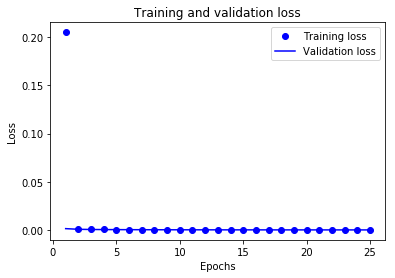

In [155]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

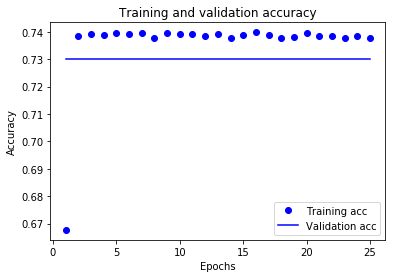

In [156]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

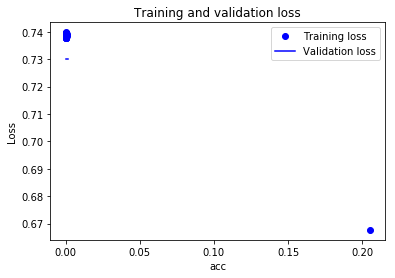

In [157]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
plt.plot(loss, acc, 'bo', label='Training loss')
plt.plot(val_loss, val_acc, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('acc')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [158]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

NameError: name 'X_validate' is not defined